#Install Library

In [ ]:
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.4 MB/s eta 0:00:00


In [ ]:
%%capture
!unzip /content/drive/MyDrive/eeg_depression_preprocessed.zip -d eeg_depression_preprocessed ##put your preprocessed data path

In [ ]:
import os
import numpy as np
import pandas as pd
import re

import mne

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix

from tqdm import tqdm

from tensorflow.keras.utils import to_categorical

from scipy.signal import welch
from scipy.integrate import simps

np.set_printoptions(suppress=True)

from numpy.random import seed
seed(2023)
from tensorflow.random import set_seed
set_seed(2023)

#Load and Prepare Data

In [ ]:
fp = '/content/eeg_depression_preprocessed/'

EO = []
for file in os.listdir(fp):
  path = os.path.join(fp,file)
  if 'EO' in path:
    EO.append(path)
healthyEO_fp = sorted([i for i in EO if 'H' in i])
mddEO_fp = sorted([i for i in EO if 'MDD' in i])

EC = []
for file in os.listdir(fp):
  path = os.path.join(fp,file)
  if 'EC' in path:
    EC.append(path)
healthyEC_fp = sorted([i for i in EC if 'H' in i])
mddEC_fp = sorted([i for i in EC if 'MDD' in i])

In [ ]:
healthyEC_id = [int(re.findall(r'\d+', fp)[0]) for fp in healthyEC_fp]
healthyEO_id = [int(re.findall(r'\d+', fp)[0]) for fp in healthyEO_fp]

mddEC_id = [int(re.findall(r'\d+', fp)[0]) for fp in mddEC_fp]
mddEO_id = [int(re.findall(r'\d+', fp)[0]) for fp in mddEO_fp]

EC_id = healthyEC_id + mddEC_id
EO_id = healthyEO_id + mddEO_id

In [ ]:
def read_data_epoch(fp, duration, overlap=5):
  data = mne.io.read_raw_edf(fp, preload=True)
  time = data.__len__()/256
  data.crop(tmin=30, tmax=time-30)
  epochs = mne.make_fixed_length_epochs(data, duration=duration, overlap=overlap)
  arr = epochs.get_data()
  return arr

In [ ]:
def get_data_epoch(healthy_fp, mdd_fp, duration, overlap=5):
  healthy_data_epoch = [read_data_epoch(i, duration, overlap) for i in healthy_fp]
  mdd_data_epoch = [read_data_epoch(i, duration, overlap) for i in mdd_fp]

  healthy_label_epoch = [len(i)*[0] for i in healthy_data_epoch]
  mdd_label_epoch = [len(i)*[1] for i in mdd_data_epoch]

  data_epoch = healthy_data_epoch + mdd_data_epoch
  label_epoch = healthy_label_epoch + mdd_label_epoch
  group = [[i]*len(j) for i,j in enumerate(data_epoch)]

  arr_epoch = np.vstack(data_epoch)
  label_arr_epoch = np.hstack(label_epoch)
  group_arr_epoch = np.hstack(group)

  return arr_epoch, label_arr_epoch, group_arr_epoch

In [ ]:
%%capture
EO_arr_epoch, EO_labelarr_epoch, EO_grouparr = get_data_epoch(healthyEO_fp, mddEO_fp, 16, 1)
EC_arr_epoch, EC_labelarr_epoch, EC_grouparr = get_data_epoch(healthyEC_fp, mddEC_fp, 16, 1)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def prep_data(data, label, group, seed=0, train_size=0.8, val_size=0.1, test_size=0.1, norm=True, categorical=False):
  train_size_ = train_size/(1-test_size)
  gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size+val_size, random_state=2023)
  gss2 = GroupShuffleSplit(n_splits=1, train_size=train_size_, random_state=seed+1)

  for i, (dev_index, test_index) in enumerate(gss1.split(data, label, group)):
    X_dev = data[dev_index]
    X_test = data[test_index]
    y_dev = label[dev_index]
    y_test = label[test_index]
    group_dev = group[dev_index]
    group_test = group[test_index]

    for i, (train_index, val_index) in enumerate(gss2.split(X_dev, y_dev, group_dev)):
      X_train = X_dev[train_index]
      X_val = X_dev[val_index]
      y_train = y_dev[train_index]
      y_val = y_dev[val_index]
      group_train = group_dev[train_index]
      group_val = group_dev[val_index]

  if categorical ==True:
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

  if norm==True:
    X_train_norm = []
    X_val_norm = []
    X_test_norm = []

    for i in range(X_train.shape[0]):
        X_train_norm.append(np.expand_dims((X_train[i] - np.mean(X_train[i], keepdims=True)) / np.std(X_train[i], keepdims=True), axis=0))

    for i in range(X_val.shape[0]):
        X_val_norm.append(np.expand_dims((X_val[i] - np.mean(X_val[i], keepdims=True)) / np.std(X_val[i], keepdims=True), axis=0))

    for i in range(X_test.shape[0]):
        X_test_norm.append(np.expand_dims((X_test[i] - np.mean(X_test[i], keepdims=True)) / np.std(X_test[i], keepdims=True), axis=0))

    X_train_norm=np.vstack(X_train_norm)
    X_val_norm=np.vstack(X_val_norm)
    X_test_norm=np.vstack(X_test_norm)

    return X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test, group_train, group_val, group_test

  elif norm==False:
    return X_train, X_val, X_test, y_train, y_val, y_test, group_train, group_val, group_test

In [ ]:
def get_arr(df, col_used, groupby=None):
  """
    groupby = (group:str, func:list)

  """
  df = df.reset_index()
  label = [0 if df.loc[i,'group'] == 'Healthy' else 1 for i in range(0,len(df),19)]
  Feat = []
  feat = []

  if groupby != None:
    group, func = groupby
    n_group = len(set(df[group]))
    groups = ['trial']
    groups.append(group)
    df_ = df.groupby(groups).aggregate(func).reset_index()

    for i in range(len(df_)):
      feat.append(df_.loc[i,col_used].values)
      if (i+1)%n_group == 0:
        Feat.append(feat)
        feat = []
    arr = np.array(Feat)

  else:
    for i in range(len(df)):
      feat.append(df.loc[i,col_used].values)
      if (i+1)%19 == 0:
        Feat.append(feat)
        feat = []
    arr = np.array(Feat)

  return arr, np.array(label)

In [ ]:
EC_df = pd.read_csv("/content/drive/MyDrive/eeg_depression/EC_df.csv", index_col=0)
EO_df = pd.read_csv("/content/drive/MyDrive/eeg_depression/EO_df.csv", index_col=0)

In [ ]:
EC_feats, EC_labels = get_arr(EC_df, ['delta', 'theta', 'alpha', 'beta', 'samp_entropy', 'higuchi_fd', 'hurst_exp'])
EO_feats, EO_labels = get_arr(EO_df, ['delta', 'theta', 'alpha', 'beta', 'samp_entropy', 'higuchi_fd', 'hurst_exp'])

EC_feats = EC_feats.astype('float64')
EO_feats = EO_feats.astype('float64')

In [ ]:
train, val, EC_test_feats, train_y, val_y, EC_test_y, _, _, _= prep_data(EC_feats, EC_labels, EC_grouparr, norm=False)
EC_dev_feats = np.vstack([train,val])
EC_dev_y = np.hstack([train_y,val_y])

train, val, EO_test_feats, train_y, val_y, EO_test_y, _, _, _ = prep_data(EO_feats, EO_labels, EO_grouparr, norm=False)
EO_dev_feats = np.vstack([train,val])
EO_dev_y = np.hstack([train_y,val_y])

train, val, EC_test_signal, train_y, val_y, EC_test_y_, _, _, _ = prep_data(EC_arr_epoch, EC_labels, EC_grouparr, categorical=True)
EC_dev_signal = np.vstack([train,val])
EC_dev_y_ = np.vstack([train_y,val_y])

train, val, EO_test_signal, train_y, val_y, EO_test_y_, _, _, _ = prep_data(EO_arr_epoch, EO_labels, EO_grouparr, categorical=True)
EO_dev_signal = np.vstack([train,val])
EO_dev_y_ = np.vstack([train_y,val_y])

#ML

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
#define evaluation metrics

params = ["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"]

def evaluate(model, X, Y, params):
    results = []

    predicted = model.predict(X)

    for param in params:
      if param == "acc":
        results.append(accuracy_score(Y, predicted))
      if param == "recall":
        results.append(recall_score(Y, predicted, zero_division=0))
      if param == "precision":
        results.append(precision_score(Y, predicted, zero_division=0))
      if param == "f1":
        results.append(f1_score(Y, predicted, zero_division=0))
      if param == "roc_auc":
        results.append(roc_auc_score(Y, predicted))

    return results

def evaluate_nn(model, X, Y, params):
    results = []

    predicted = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(Y, np.round(predicted.reshape(-1,)[:len(Y)])).ravel()

    for param in params:
      if param == "acc":
        results.append(accuracy_score(Y, np.round(predicted.reshape(-1,)[:len(Y)])))
      if param == "recall":
        results.append(recall_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
      if param == "precision":
        results.append(precision_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
      if param == "f1":
        results.append(f1_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
      if param == "roc_auc":
        results.append(roc_auc_score(Y, np.round(predicted.reshape(-1,)[:len(Y)])))
      if param == "sensitivity":
        results.append(tp/(tp+fn))
      if param == "specificity":
        results.append(tn/(tn+fp))

    return results

def evaluate_dl(model, X, Y, params, return_cm=False):
    results = []

    Y = np.argmax(Y, axis=1)
    predicted = model.predict(X)
    cm=confusion_matrix(Y, np.argmax(predicted, axis=1))
    tn, fp, fn, tp = cm.ravel()

    for param in params:
      if param == "acc":
        results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
      if param == "recall":
        results.append(recall_score(Y, np.argmax(predicted, axis=1),zero_division=0))
      if param == "precision":
        results.append(precision_score(Y, np.argmax(predicted, axis=1),zero_division=0))
      if param == "f1":
        results.append(f1_score(Y, np.argmax(predicted, axis=1),zero_division=0))
      if param == "roc_auc":
        results.append(roc_auc_score(Y, np.argmax(predicted, axis=1)))
      if param == "sensitivity":
        results.append(tp/(tp+fn))
      if param == "specificity":
        results.append(tn/(tn+fp))
    if return_cm==True:
      return results, cm
    else:
      return results

In [ ]:
## Blind test set

def data_split(data, labels, groups, test_size):
  gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=2023)

  for i, (dev_index, test_index) in enumerate(gss.split(data, labels, groups)):
    X_dev = data[dev_index]
    X_test = data[test_index]
    y_dev = labels[dev_index]
    y_test = labels[test_index]
    group_dev = groups[dev_index]
    group_test = groups[test_index]

    return X_dev, X_test, y_dev, y_test, group_dev, group_test

In [ ]:
channels = ['Fp1','F3','C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Fz', 'Cz', 'Pz']
feats = ['delta', 'theta', 'alpha', 'beta', 'samp_entropy', 'higuchi_fd', 'hurst_exp']

feat_names=[]
for feat in feats:
  for ch in channels:
    feat_names.append(feat+'_'+ch)

sr=256
duration=16
C=19
T=sr*duration
F1=8
D=1
F2=F1*D

##Feature Selection

In [ ]:
EC_train, EC_val, EC_test, EC_y_train, EC_y_val, EC_y_test,_,_,_ = prep_data(EC_feats, EC_labels, EC_grouparr, seed=20, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

scaler = StandardScaler()
EC_train = scaler.fit_transform(EC_train.reshape(EC_train.shape[0],-1))
EC_val = scaler.transform(EC_val.reshape(EC_val.shape[0],-1))
EC_test = scaler.transform(EC_test.reshape(EC_test.shape[0],-1))

EC_dev = np.vstack([EC_train, EC_val])
EC_y_dev = np.hstack([EC_y_train, EC_y_val])

selector_EC = SelectKBest(k=30)
selector_EC.fit(EC_dev, EC_y_dev)

EO_train, EO_val, EO_test, EO_y_train, EO_y_val, EO_y_test,_,_,_ = prep_data(EO_feats, EO_labels, EO_grouparr, seed=20, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

scaler = StandardScaler()
EO_train = scaler.fit_transform(EO_train.reshape(EO_train.shape[0],-1))
EO_val = scaler.transform(EO_val.reshape(EO_val.shape[0],-1))
EO_test = scaler.transform(EO_test.reshape(EO_test.shape[0],-1))

EO_dev = np.vstack([EO_train, EO_val])
EO_y_dev = np.hstack([EO_y_train, EO_y_val])

selector_EO = SelectKBest(k=30)
selector_EO.fit(EO_dev, EO_y_dev)

SelectKBest(k=30)

In [ ]:
def k_fold_cv_select(data, labels, groups, classifier, selector, n_fold=5, metrics = ["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"]):
  df_fold_score = pd.DataFrame(columns=metrics, index=['fold {}'.format(str(n)) for n in range(1,n_fold+1)]+['average'])
  for fold in tqdm(range(n_fold)):
    X_train, X_val, X_test, y_train, y_val, y_test,_,_,_ = prep_data(data, labels, groups, seed=fold*10+10, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1))
    X_val = scaler.transform(X_val.reshape(X_val.shape[0],-1))
    X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1))

    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)

    y_train_ = np.hstack([y_train, y_val])

    X_train_shuffled, y_train_shuffled = shuffle(X_train_selected, y_train, random_state=0)
    classifier.fit(X_train_shuffled, y_train_shuffled)
    clf_score = evaluate(classifier, X_val_selected, y_val, metrics)
    df_fold_score.loc['fold {}'.format(str(fold+1))] = clf_score
  df_fold_score.loc['average'] = df_fold_score.mean(axis=0)
  return df_fold_score

In [ ]:
clf_EO = SVC(C=0.1, gamma=0.1) ##best parameters from experiments
clf_EC =SVC(C=1000, gamma=0.01)

In [ ]:
EC_fold_score_select = k_fold_cv_select(EC_feats, EC_labels, EC_grouparr, clf_EC, selector_EC, 10)
EO_fold_score_select = k_fold_cv_select(EO_feats, EO_labels, EO_grouparr, clf_EO, selector_EO, 10)

EC_fold_score_select.to_csv("/content/drive/MyDrive/eeg_depression/score/EC/EC_fold_score_select_10fold_senspec.csv")
EO_fold_score_select.to_csv("/content/drive/MyDrive/eeg_depression/score/EO/EO_fold_score_select_10fold_senspec.csv")

100%|██████████| 10/10 [00:00<00:00, 21.58it/s]


##PCA

In [ ]:
#define metrics
params = ["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"]
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
def evaluate(model, X, Y, params):
    results = []

    predicted = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(Y, predicted).ravel()

    for param in params:
      if param == "acc":
        results.append(accuracy_score(Y, predicted))
      if param == "recall":
        results.append(recall_score(Y, predicted, zero_division=0))
      if param == "precision":
        results.append(precision_score(Y, predicted, zero_division=0))
      if param == "f1":
        results.append(f1_score(Y, predicted, zero_division=0))
      if param == "roc_auc":
        results.append(roc_auc_score(Y, predicted))
      if param == "sensitivity":
        results.append(tp/(tp+fn))
      if param == "specificity":
        results.append(tn/(tn+fp))

    return results

In [ ]:
EC_train, EC_val, EC_test, EC_y_train, EC_y_val, EC_y_test , _, _, _= prep_data(EC_feats, EC_labels, EC_grouparr, seed=20, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

scaler = StandardScaler()
EC_train = scaler.fit_transform(EC_train.reshape(EC_train.shape[0],-1))
EC_val = scaler.transform(EC_val.reshape(EC_val.shape[0],-1))
EC_test = scaler.transform(EC_test.reshape(EC_test.shape[0],-1))

EC_dev = np.vstack([EC_train, EC_val])
EC_y_dev = np.hstack([EC_y_train, EC_y_val])

pca_EC = PCA(n_components=n_com)
pca_EC.fit(EC_dev, EC_y_dev)

EO_train, EO_val, EO_test, EO_y_train, EO_y_val, EO_y_test,_,_,_ = prep_data(EO_feats, EO_labels, EO_grouparr, seed=20, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

scaler = StandardScaler()
EO_train = scaler.fit_transform(EO_train.reshape(EO_train.shape[0],-1))
EO_val = scaler.transform(EO_val.reshape(EO_val.shape[0],-1))
EO_test = scaler.transform(EO_test.reshape(EO_test.shape[0],-1))

EO_dev = np.vstack([EO_train, EO_val])
EO_y_dev = np.hstack([EO_y_train, EO_y_val])

pca_EO = PCA(n_components=n_com)
pca_EO.fit(EO_dev, EO_y_dev)

PCA(n_components=10)

In [ ]:
clf_EO = SVC(C=1, gamma=0.01)  ##best parameters from experiments
clf_EC = SVC(C=1000, gamma=0.01)

In [ ]:
def k_fold_cv_pca(data, labels, groups, classifier, pca, n_fold=5, metrics = ["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"]):
  df_fold_score = pd.DataFrame(columns=metrics, index=['fold {}'.format(str(n)) for n in range(1,n_fold+1)]+['average'])
  for fold in tqdm(range(n_fold)):
    X_train, X_val, X_test, y_train, y_val, y_test,_, _, _ = prep_data(data, labels, groups, seed=fold*10+10, train_size=0.8, val_size=0.1, test_size=0.1, norm=False, categorical=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1))
    X_val = scaler.transform(X_val.reshape(X_val.shape[0],-1))
    X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1))

    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)

    y_train_ = np.hstack([y_train, y_val])

    X_train_shuffled, y_train_shuffled = shuffle(X_train_pca, y_train, random_state=0)
    classifier.fit(X_train_shuffled, y_train_shuffled)
    clf_score = evaluate(classifier, X_val_pca, y_val, metrics)
    df_fold_score.loc['fold {}'.format(str(fold+1))] = clf_score
  df_fold_score.loc['average'] = df_fold_score.mean(axis=0)
  return df_fold_score

In [ ]:
EC_fold_score_pca = k_fold_cv_pca(EC_feats, EC_labels, EC_grouparr, clf_EC, pca_EC, 10)
EO_fold_score_pca = k_fold_cv_pca(EO_feats, EO_labels, EO_grouparr, clf_EO, pca_EO, 10)

EC_fold_score_pca.to_csv("/content/drive/MyDrive/eeg_depression/score/EC/EC_fold_score_pca_10fold_senspec.csv")
EO_fold_score_pca.to_csv("/content/drive/MyDrive/eeg_depression/score/EO/EO_fold_score_pca_10fold_senspec.csv")

100%|██████████| 10/10 [00:00<00:00, 39.14it/s]


##NN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.utils import to_categorical

from keras.backend import int_shape

In [ ]:
def build_nn(in_shape, n_filter=2):
  input = layers.Input(shape=in_shape)
  x = layers.Reshape((int_shape(input)[1], 1))(input)
  x = layers.Conv1D(n_filter, 19, strides=19)(x)
  x = layers.Flatten()(x)
  x= layers.Dense(32, activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  x= layers.Dense(16, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  out = layers.Dense(1, activation='sigmoid')(x)
  return Model(input, out)

In [ ]:
model = build_nn((19*7))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 133)]             0         
                                                                 
 reshape_4 (Reshape)         (None, 133, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 2)              40        
                                                                 
 flatten_1 (Flatten)         (None, 14)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                480       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528 

In [ ]:
def kfold_cv(data, label, group, n_fold=5, optimizer='adam', loss='binary_crossentropy', params=["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"], c=19, t=30):
  history = {}
  df_fold_score = pd.DataFrame(columns=params, index=['fold {}'.format(str(n)) for n in range(1,n_fold+1)])
  for fold in tqdm(range(n_fold)):
    X_train, X_val, X_test, y_train, y_val, y_test, _, _, _ = prep_data(data, label, group, seed=fold*10+10, norm=False, categorical=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1))
    X_val = scaler.transform(X_val.reshape(X_val.shape[0],-1))
    X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1))

    model_ = build_nn(X_train.shape[1:])
    model_.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history['fold {}'.format(fold+1)] = model_.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val))
    df_fold_score.loc['fold {}'.format(str(fold+1))] = evaluate_nn(model_, X_val, y_val, params)
    df_fold_score.loc['average'] = df_fold_score.mean(axis=0)

  return history, df_fold_score

In [ ]:
EC_history_nn, EC_fold_score_nn = kfold_cv(EC_feats, EC_labels, EC_grouparr, n_fold=10, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='binary_crossentropy')
EO_history_nn, EO_fold_score_nn = kfold_cv(EO_feats, EO_labels, EO_grouparr, n_fold=10, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='binary_crossentropy')

In [ ]:
EC_fold_score_nn.to_csv("/content/drive/MyDrive/eeg_depression/score/EC/dl/EC_fold_score_nn_10fold.csv")
EO_fold_score_nn.to_csv("/content/drive/MyDrive/eeg_depression/score/EO/dl/EO_fold_score_nn_10fold.csv")

## End-to-End

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten, Reshape, Concatenate

In [ ]:
#k-fold cv

def kfold_cv(data, label, group, model='eegnet', n_fold=5, optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', params=["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"], c=19, t=16):
  history = {}
  df_fold_score = pd.DataFrame(columns=params, index=['fold {}'.format(str(n)) for n in range(1,n_fold+1)])
  for fold in tqdm(range(n_fold)):
    if model=='eegnet':
      model_ = EEGNet(2,channels=c, samples=t*256)

    if model=='dpnet':
      model_ = DepressioNet(2,channels=c, samples=t*256)

    model_.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    X_train, X_val, X_test, y_train, y_val, y_test, _, _, _ = prep_data(data, label, group, seed=fold*10+10, categorical=True)
    history['fold {}'.format(fold+1)] = model_.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))
    df_fold_score.loc['fold {}'.format(str(fold+1))] = evaluate_dl(model_, X_test, y_test, params)
    df_fold_score.loc['average'] = df_fold_score.mean(axis=0)

  return history, df_fold_score

###EEGNet

State-of-the-art model from this paper [EEGNet: A Compact Convolutional Network for EEG-based Brain-Computer Interfaces](http://arxiv.org/abs/1611.08024)

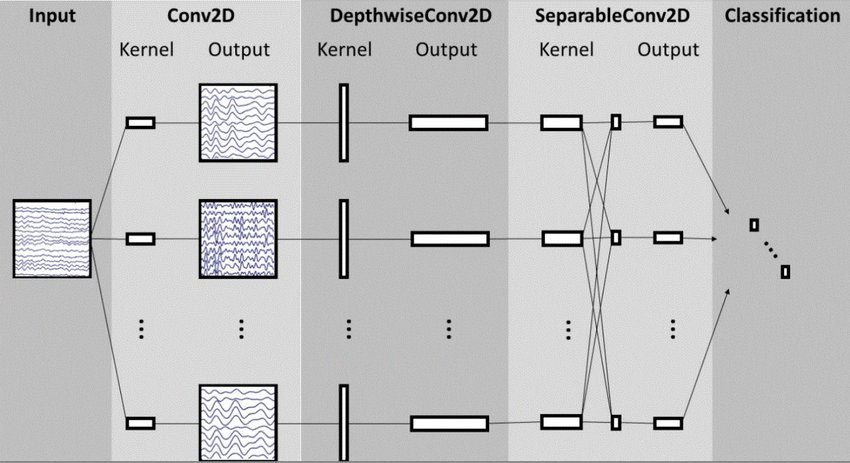

In [ ]:
def EEGNet(classes, channels = 19, samples = 256*30,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (channels, samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (channels, samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((channels, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [ ]:
EC_history_eegnet, EC_fold_score_eegnet = kfold_cv(EC_arr_epoch, EC_labelarr_epoch, EC_grouparr, 'eegnet', n_fold=10, t=duration)
EO_history_eegnet, EO_fold_score_eegnet = kfold_cv(EO_arr_epoch, EO_labelarr_epoch, EO_grouparr, 'eegnet', n_fold=10, t=duration)

In [ ]:
EC_fold_score_eegnet.to_csv("/content/drive/MyDrive/eeg_depression/score/EC/dl/EC_fold_score_eegnet_10fold.csv")
EO_fold_score_eegnet.to_csv("/content/drive/MyDrive/eeg_depression/score/EO/dl/EO_fold_score_eegnet_10fold.csv")

### DepressioNet

I have developed the End-to-End network for depression classification using this following architecture

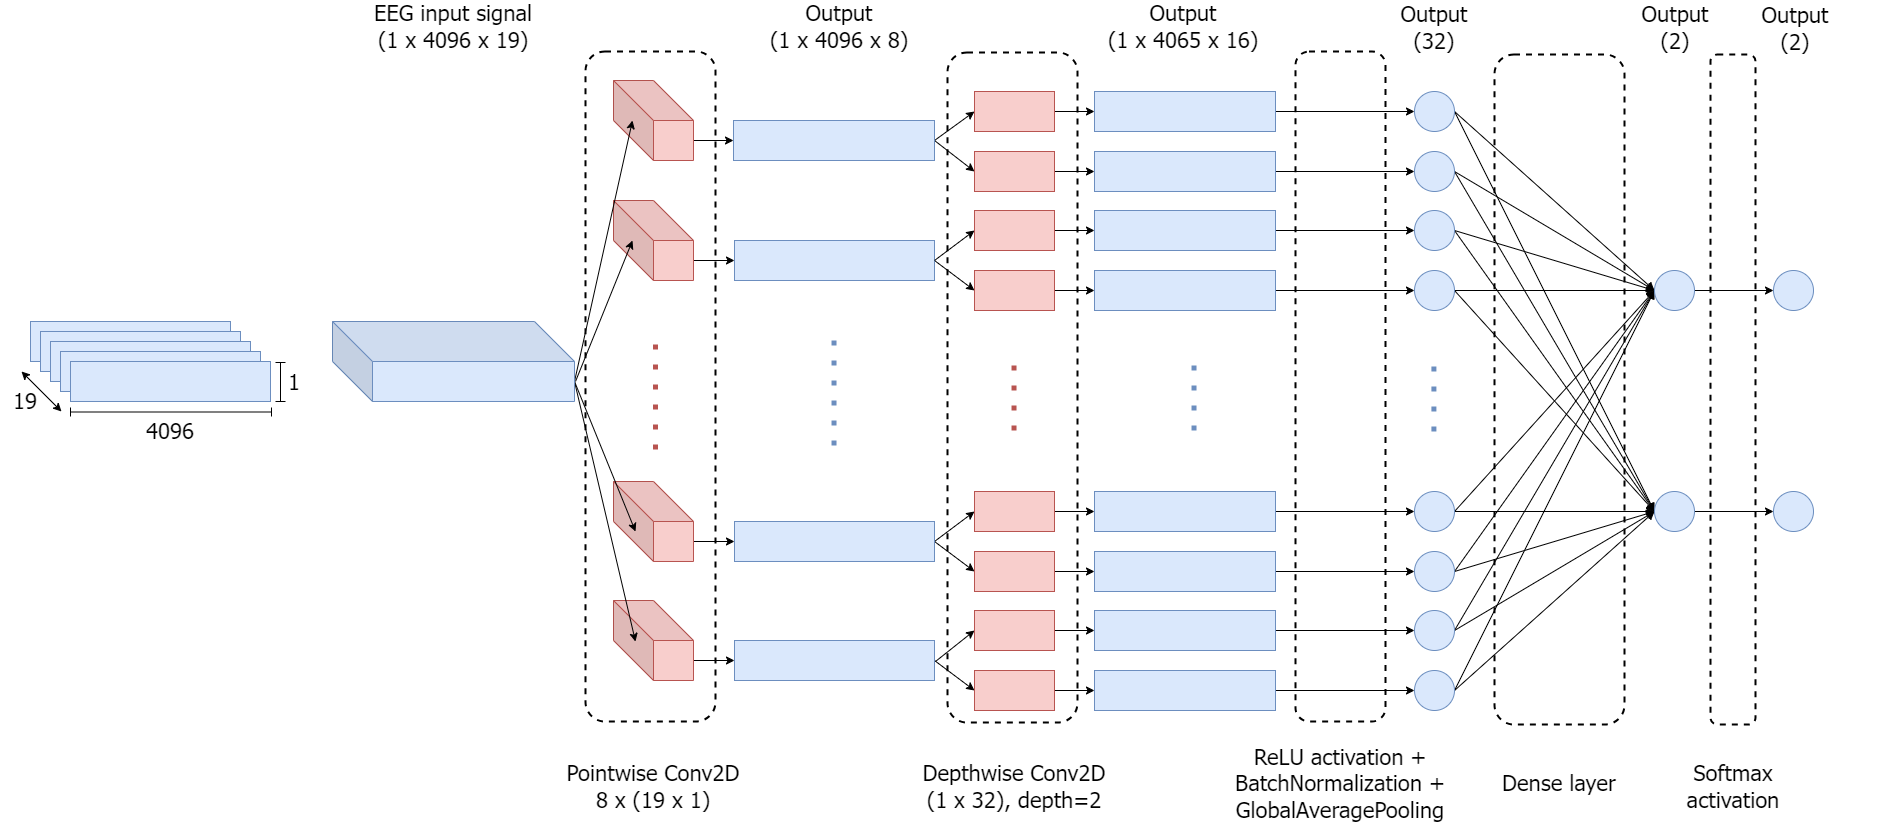

In [ ]:
def DepressioNet(classes=2, channels=19, samples=256*16 ,N1=8, d=2, kernelLength=32):
  input = Input(shape = (channels, samples))
  x = Permute((2,1))(input)
  x = Reshape((1, samples, channels))(x)
  x = Conv2D(filters=N1, kernel_size=(channels, 1), strides=1, padding='same')(x)
  x = DepthwiseConv2D(kernel_size=(1, kernelLength), strides=1, padding='valid', depth_multiplier=d)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = AveragePooling2D(pool_size=(1, samples-kernelLength+1))(x)
  x = Reshape((-1,))(x)
  out = Dense(classes, activation='softmax')(x)

  return Model(inputs=input, outputs=out)

In [ ]:
model_dpnet = DepressioNet(samples=T, N1=8)
model_dpnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 4096)]        0         
                                                                 
 permute (Permute)           (None, 4096, 19)          0         
                                                                 
 reshape (Reshape)           (None, 1, 4096, 19)       0         
                                                                 
 conv2d (Conv2D)             (None, 1, 4096, 8)        2896      
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 4065, 16)      528       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 1, 4065, 16)       0         
                                                             

In [ ]:
EC_history_dpnet, EC_fold_score_dpnet = kfold_cv(EC_arr_epoch, EC_labelarr_epoch, EC_grouparr, 'dpnet', n_fold=10, t=duration)
EO_history_dpnet, EO_fold_score_dpnet = kfold_cv(EO_arr_epoch, EO_labelarr_epoch, EO_grouparr, 'dpnet', n_fold=10, t=duration)

In [ ]:
EC_fold_score_dpnet.to_csv("/content/drive/MyDrive/eeg_depression/score/EC/dl/EC_fold_score_dpnet_10fold.csv")
EO_fold_score_dpnet.to_csv("/content/drive/MyDrive/eeg_depression/score/EO/dl/EO_fold_score_dpnet_10fold.csv")

In [ ]:
scores, cm = evaluate_dl(model_dpnet, EC_test_signal, EC_test_y_, params = ["acc","recall","precision","f1", "roc_auc", "sensitivity",  "specificity"], return_cm= True)

3/3 [==============================] - 0s 18ms/step


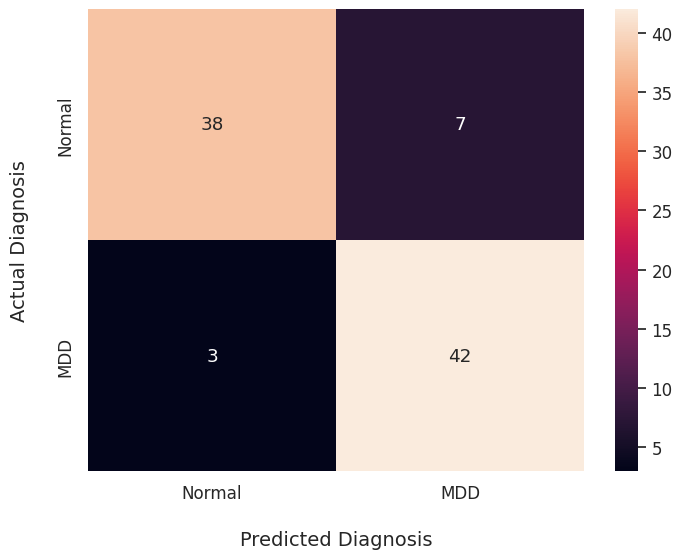

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)

ax = sns.heatmap(cm, annot=True, fmt='d', )

ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Normal', 'MDD'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Normal', 'MDD'])

plt.show()

In [ ]:
scores

[0.8888888888888888,
 0.9333333333333333,
 0.8571428571428571,
 0.8936170212765957,
 0.8888888888888888,
 0.9333333333333333,
 0.8444444444444444]